# Introduction

The database was collected by Elaine Fehrman between March 2011 and March 2012. The study recruited 1885 participants. 

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
%matplotlib inline
plt.style.use(['ggplot'])
sns.set()

# First Glance at the Dataset

In [2]:
df_raw = pd.read_excel('data/drug_consumption.xls')

In [3]:
df_raw.shape

(1885, 32)

In [4]:
df_raw.columns

Index(['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
       'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Alcohol',
       'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack',
       'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Shrooms',
       'Nicotine', 'Semer', 'VSA'],
      dtype='object')

| Column name   | Description                                        | Key | Type |
|:--------------|:---------------------------------------------------|:----|:-:|
| ID     | number of record in original database                                 |     | metric |
| Age         | age of participant and has one of the values                 |  0=18-24, 1=25-34, 2=35-44, 3=45-54, 4=55-64, 5=65+   |  intervall |
| Gender  |  gender of participant | 0=male, 1=female  | dichotomous |
| Education  |  level of education of participant | 0=Left school before 16 years, 1=Left school at 16 years, 2=Left school at 17 years, 3=Left school at 18 years, 4=Some college or university, no certificate or degree, 5=Professional certificate/ diploma, 6=University degree, 7=Masters degree, 8=Doctorate degree | ordinal |
| Country | country of current residence of participant | | nominal |
| Ethnicity | ethnicity of participant | | nominal |
| Nscore | NEO-FFI-R Neuroticism |  |
| Escore | NEO-FFI-R Extraversion |  |
| Oscore | NEO-FFI-R Openness to experience |  |
| Ascore | NEO-FFI-R Agreeableness |  |
| Cscore | NEO-FFI-R Conscientiousness |  |
| Impulsive | impulsiveness measured by BIS-11 |  |
| SS | sensation seeing measured by ImpSS |  |
| Alcohol | alcohol consumption | CL0 - CL6 | class |
| Amphet | class of amphetamines consumption | CL0 - CL6 | class |
| Amyl | class of amyl nitrite consumption | CL0 - CL6 | class |
| Benzos | class of benzodiazepine consumption | CL0 - CL6 | class |
| Caff | class of caffeine consumption | CL0 - CL6 | class |
| Cannabis | class of cannabis consumption | CL0 - CL6 | class |
| Choc | class of chocolate consumption | CL0 - CL6 | class |
| Coke | class of cocaine consumption | CL0 - CL6 | class |
| Crack | class of crack consumption | CL0 - CL6 | class |
| Ecstasy | class of ecstasy consumption | CL0 - CL6 | class |
| Heroin | class of heroin consumption | CL0 - CL6 | class |
| Ketamine | class of ketamine consumption | CL0 - CL6 | class |
| Legalh | class of legal highs consumption | CL0 - CL6 | class |
| LSD | class of LSD consumption | CL0 - CL6 | class |
| Meth | class of methadone consumption | CL0 - CL6 | class |
| Shrooms | class of magic mushrooms consumption | CL0 - CL6 | class |
| Nicotine | class of nicotine consumption | CL0 - CL6 | class |
| Semer | class of fictitious drug Semeron consumption | CL0 - CL6 | class |
| VSA | class of volatile substance abuse consumption | CL0 - CL6 | class |

| Key | meaning |
|:----|:--------|
| CL0 | Never Used |
| CL1 | Used over a Decade Ago |
| CL2 | Used in Last Decade |
| CL3 | Used in Last Year |
| CL4 | Used in Last Month |
| CL5 | Used in Last Week |
| CL6 | Used in Last Day |

In [5]:
df_raw.sample(10)

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,Semer,VSA
1373,1377,0.49788,-0.48246,0.45468,-0.28519,-0.31685,1.49158,-0.57545,0.88309,-1.62090,-0.40581,-0.21712,0.76540,CL5,CL2,CL1,CL6,CL6,CL2,CL6,CL2,CL3,CL2,CL2,CL2,CL2,CL2,CL6,CL2,CL2,CL0,CL1
84,85,1.09449,-0.48246,-1.73790,0.96082,-0.31685,-0.34799,0.16767,-0.31776,-0.30172,-0.14277,-1.37983,0.07987,CL5,CL0,CL0,CL0,CL6,CL2,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0
1120,1124,-0.95197,-0.48246,-1.73790,0.24923,-0.31685,-0.05188,-1.92173,1.65653,-0.01729,-0.40581,-0.71126,-0.52593,CL3,CL2,CL0,CL2,CL6,CL3,CL4,CL3,CL2,CL2,CL0,CL2,CL2,CL2,CL4,CL2,CL6,CL0,CL0
31,32,0.49788,0.48246,-1.73790,-0.28519,-0.31685,-1.19430,-0.80615,0.14143,-0.60633,-0.00665,-1.37983,-0.84637,CL3,CL0,CL0,CL2,CL3,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
219,220,0.49788,0.48246,-0.61113,0.96082,-0.31685,-0.34799,-0.57545,0.14143,1.11406,0.25953,-1.37983,-0.84637,CL6,CL1,CL1,CL1,CL4,CL1,CL5,CL2,CL0,CL1,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
532,535,-0.07854,-0.48246,1.16365,0.96082,-0.31685,-0.34799,-0.15487,-0.71727,-1.62090,-0.65253,0.52975,0.07987,CL4,CL0,CL0,CL0,CL5,CL0,CL6,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0
1656,1660,1.09449,0.48246,0.45468,0.96082,-0.31685,-2.21844,0.63779,0.29338,0.13136,0.41594,-1.37983,-0.84637,CL6,CL0,CL0,CL0,CL6,CL0,CL6,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
1432,1436,1.82213,0.48246,1.16365,0.96082,-0.31685,-0.79151,0.00332,0.14143,0.28783,0.75830,0.52975,-0.52593,CL6,CL1,CL1,CL0,CL6,CL1,CL6,CL1,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL6,CL0,CL0
312,315,-0.95197,0.48246,-1.22751,0.21128,-0.31685,-0.58016,0.16767,-0.71727,0.13136,-0.14277,-0.71126,-1.18084,CL5,CL0,CL0,CL0,CL6,CL0,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL5,CL0,CL0
761,765,-0.95197,-0.48246,-1.73790,0.96082,-0.31685,0.41667,-0.94779,1.06238,0.59042,-1.01450,0.52975,0.76540,CL5,CL0,CL2,CL0,CL4,CL5,CL3,CL2,CL0,CL3,CL0,CL2,CL2,CL3,CL0,CL3,CL4,CL0,CL0


In [6]:
df_raw.describe()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
count,1885.000000,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [7]:
df_raw.ID.nunique()

1885

In [8]:
np.sort(df_raw.Alcohol.unique())

array(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], dtype=object)

Columns with drugs have 7 classes. They could transform to an integer value.

In [9]:
df = df_raw.copy()

Create dictionary of quantified country values and their corresponding annotation.

### Feature Explanation

**Education**: The sample recruited was highly educated, with just under two thirds (59.5%) educated to, at a minimum, degree or professional certificate level: 14.4% (271) reported holding a professional certificate or diploma, 25.5% (n = 481) an undergraduate degree, 15% (n = 284) a master’s degree, and 4.7% (n = 89) a doctorate. Approximately 26.8% (n = 506) of the sample had received some college or university tuition although they did not hold any certificates; lastly, 257 (13.6%) had left school at the age of 18 or younger. *Original scale: ordinal*
 
**Country**: The snowball sampling methodology recruited a primarily (93.5%) native English-speaking sample, with participants from the UK (1044; 55.4%), the USA (557; 29.5%), Canada (87; 4.6%), Australia (54; 2.9%), New Zealand (5; 0.3%) and Ireland (n = 20; 1.1%). A total of 118 (6.3%) came from a diversity of other countries. *Original scale: nominal*
 
**Ethnicity**: An overwhelming majority (91.2%; 1720) reported being White, 1.8% (33) stated they were Black, and 1.4% (26) Asian. The remainder of the sample (5.6%; 106) described themselves as ‘Other’ or ‘Mixed’ categories. *Original scale: nominal*
 
Questions out of *NEO-FFI-R*: The statements and indicate on a five-point Likert scale how much a given item applied to them (i.e. 0 = ‘Strongly Disagree’, 1 = ‘Disagree’, 2 = ‘Neutral’, 3 = ‘Agree’, to 4 = ‘Strongly Agree’)
 
**Nscore**: Neuroticism a long-term tendency to experience negative emotions such as nervousness, tension, anxiety and depression. *Scale: 12 - 28*
 
**Escore**: Extraversion manifested in outgoing, warm, active, assertive, talkative, cheerful, and in search of stimulation characteristics. *Scale: 16 - 30*
 
**Oscore**: Openness a general appreciation for art, unusual ideas, and imaginative, creative, unconventional, and wide interests. *Scale 24 - 37*
 
**Ascore**: Agreeableness a dimension of interpersonal relations, characterized by altruism, trust, modesty, kindness, compassion and cooperativeness. *Scale 12 - 33*
 
**Cscore**: Conscientiousness a tendency to be organized and dependable, strong-willed, persistent, reliable, and effi- cient. *Scale 17 - 31*

Questions out of *Barratt Impulsiveness Scale (BIS-11)*: 
 
**Impulsive**: Barratt Impulsiveness Scale (BIS-11). Items are aggregated, and the higher BIS-11 scores, the higher the impulsivity level. The BIS-11 is a 30-item self- report questionnaire, which measures the behavioural construct of impulsiveness, and comprises three subscales: motor impulsiveness, attentional impulsiveness, and non-planning. *Original scale: ordinal* 
 
**SS**: Impulsiveness Sensation-Seeking (ImpSS). *Original scale: ordinal*

**Drugs**: Alcohol, Amphet (amphetamines), Amyl (amyl nitrite), Benzos (benzodiazepines), Caff (caffeine), Cannabis, Choc (chocolate), Coke, Crack, Ecstasy, Heroin, Ketamine, Legalh (legal highs), LSD, Meth (methadone), Shrooms (mushrooms), Nicotine, Semer, VSA
 
*Drug Scale*: CL0 - Never Used, CL1 - Used over a Decade Ago, CL2 - Used in Last Decade, CL3 - Used in Last Year, CL4 - Used in Last Month, CL5 - Used in Last Week, CL6 - Used in Last Day

# Data Preprocessing

## Country

Here, we create a dictionary with the original values and the corresponding annotations of the countries/ethnicities. 

In [10]:
data = {'country': ['UK', 'CAN', 'USA', 'OTHER', 'AUS', 'IRE', 'NZ'], 
        'Country': list(df.Country.unique())}
df_ctr = pd.DataFrame(data)

In [11]:
# Add readable Country to DataFrame
df = pd.merge(df, df_ctr, left_on='Country', right_on='Country')

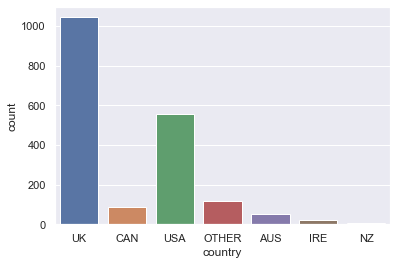

In [12]:
sns.countplot(df['country']);

## Ethnicity

In [13]:
data = {'Ethnicity': list(df.Ethnicity.unique()), 
        'ethnicity': ['mix_wh_as', 'white', 'other', 'mix_wh_bl', 'asian', 'black', 'mix_bl_as']}
df_eth = pd.DataFrame(data)

In [14]:
# Add readable Country to DataFrame
df = pd.merge(df, df_eth, left_on='Ethnicity', right_on='Ethnicity')

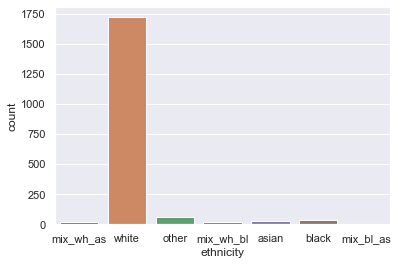

In [15]:
sns.countplot(df['ethnicity']);

## Gender

We use dummies to transform the original numerical values of gender into 0 (male) and 1 (female).  

In [16]:
dict_gender = {0.48246 : 1, -0.48246 : 0} 

df['Gender'] = df['Gender'].map(dict_gender) 
set(df['Gender'])

{0, 1}

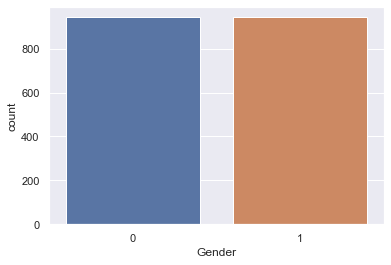

In [17]:
sns.countplot(df['Gender']);

## Drugs

Because all drug values have an 'CL' before the actual scaling, we slice out the 'CL' and merely leave the scale number in the dataframe. 

In [18]:
drugs = list(df_raw.select_dtypes(include='object').columns)
for d in drugs:
    df[d] = df[d].apply(lambda x: int(x[-1]))

In [242]:
# test-drug
drugs.remove('Semer')

In [243]:
drugs

['Alcohol',
 'Amphet',
 'Amyl',
 'Benzos',
 'Caff',
 'Cannabis',
 'Choc',
 'Coke',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'Legalh',
 'LSD',
 'Meth',
 'Shrooms',
 'Nicotine',
 'VSA']

In [20]:
# matplotlobs-Sublots for each drug

## Education

In [21]:
dict_edu = {-2.43591 : 0, -1.73790 : 1, -1.43719 : 2, -1.22751 : 3, -0.61113 : 4, 
        -0.05921 : 5, 0.45468 : 6, 1.16365 : 7, 1.98437 : 8} 

df['Education'] = df['Education'].map(dict_edu) 
set(df['Education'])

{0, 1, 2, 3, 4, 5, 6, 7, 8}

In [22]:
df.head(3)

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,Semer,VSA,country,ethnicity
0,1,0.49788,1,5,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0,UK,mix_wh_as
1,135,-0.07854,1,7,0.96082,0.126,3.27393,-1.50796,-0.31776,0.59042,-0.65253,-1.37983,0.40148,6,1,0,0,6,1,6,2,0,0,0,0,0,0,0,0,2,0,1,UK,mix_wh_as
2,192,-0.95197,0,6,0.96082,0.126,-0.34799,1.28610,-1.11902,0.59042,-0.52745,0.52975,0.07987,5,0,0,0,6,2,5,0,0,0,0,0,0,0,0,0,2,0,0,UK,mix_wh_as


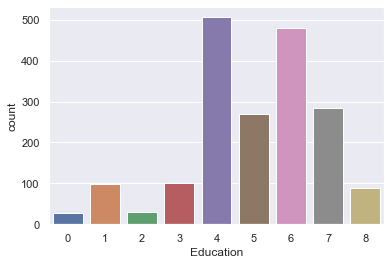

In [23]:
sns.countplot(df['Education']);

## Age

In [24]:
dict_age = {-0.95197 : 0, -0.07854 : 1, 0.49788 : 2, 1.09449 : 3, 1.82213 : 4, 
        2.59171 : 5} 

df['Age'] = df['Age'].map(dict_age) 
set(df['Age'])

{0, 1, 2, 3, 4, 5}

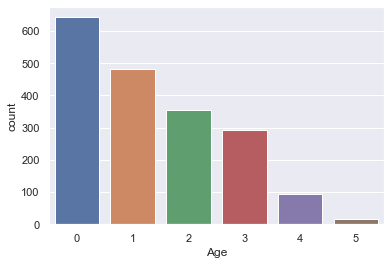

In [25]:
sns.countplot(df['Age'],);

## Drop ID

In [26]:
df.drop(columns='ID', inplace=True)

## Rename features associated to the NEO-FFI-R and the Barratt Impulsiveness Scale

In [27]:
df.rename(columns={'Ascore':'Agreeableness', 'Cscore':'Conscientiousness', 
                   'Escore':'Extraversion', 'Nscore':'Neuroticism', 
                   'Oscore':'Openness', 'SS':'Sensation-Seeking'}, inplace=True)

# Data Exploration

## Demographic Data

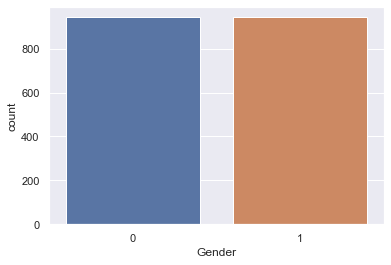

In [28]:
sns.countplot(df.Gender);

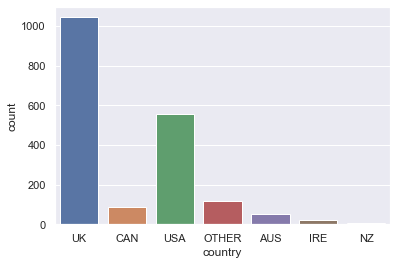

In [29]:
sns.countplot(df['country']);

The frequency plot of *country* shows, that the majority of the participants comes from the UK and USA. In her study, Fehrman (2017)states that the snowball sampling methodology lead to a recruitment of primarily (93.5%) native English-speaking people, with participants from the UK (1044; 55.4%), the USA (557; 29.5%), Canada (87; 4.6%), Australia (54; 2.9%), New Zealand (5; 0.3%) and Ireland (n = 20; 1.1%). 

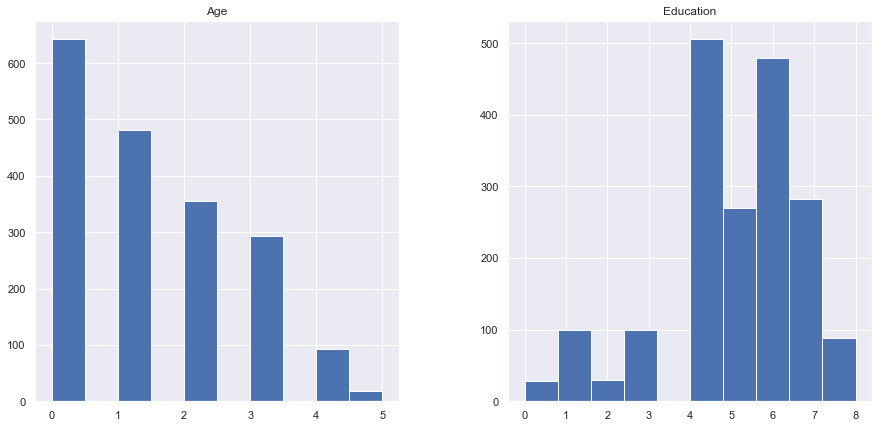

In [30]:
demographic = ['Age', 'Education']
df[demographic].hist(figsize=(15, 7));

*Histogram of demographic data that is numerical*

## Drug Usage

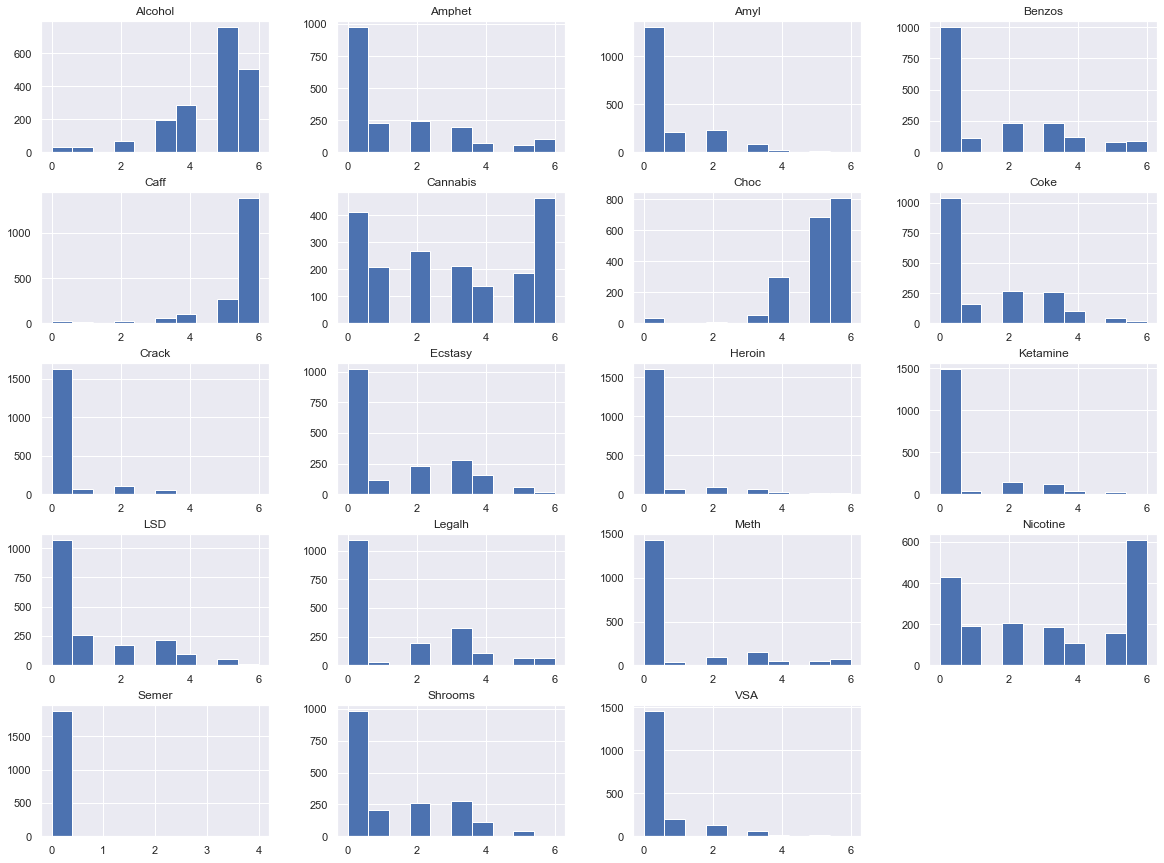

In [31]:
df[drugs].hist(figsize=(20, 15));

## Psychological Measures

*Histogram of features based on the NEO-FFI-R and the Barratt Impulsiveness Scale*

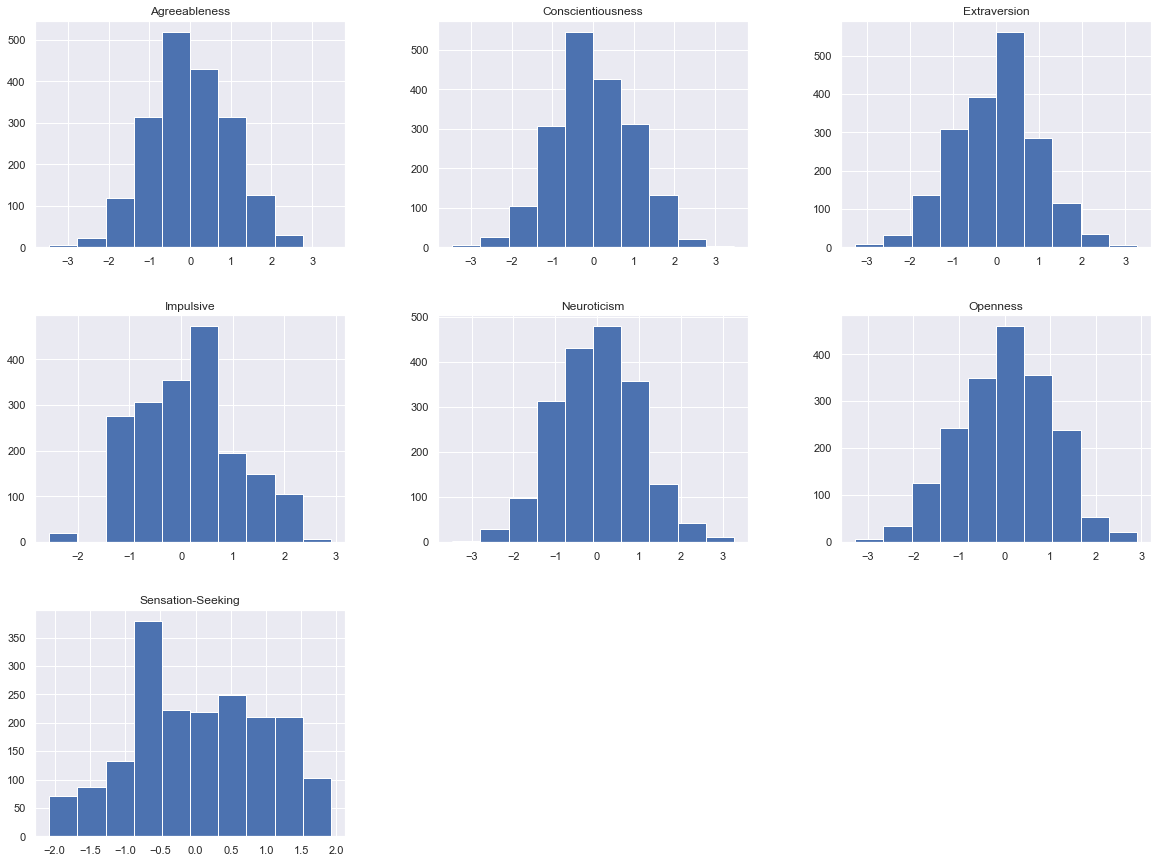

In [32]:
scores = ['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsive', 'Sensation-Seeking']
df[scores].hist(figsize=(20, 15));

As we can see, the features associated to the NEO-FFI-R and the Barratt Impulsiveness Scale are normally distributed and scaled between -3 and +3. 

# Label Engineering

## Binary classification of the label 'drug use'

The categories ‘Used in last decade’ (CL2), ‘Used over a decade ago’(CL1) and ‘Never used’ (CL0) are merged to form a group of non-users (0) and all other categories are placed into the group of users (1). This classification problem is called ‘year-based’. This classification problem is called *‘year-based’* (Elaine Fehrman et al., 2017). Here, we first replace all 0, 1, and 2 in the drug columns into 'non-users' and the remaining counts in 'user'. 

In [33]:
#replace all values with the corresponding category 

dict = {0 : 0, 1 : 0, 2 : 0, 3 : 1, 4 : 1, 5 : 1, 6 : 1} 

for d in drugs:
    df[d] = df[d].map(dict) 

In [34]:
df.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsive,Sensation-Seeking,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Shrooms,Nicotine,Semer,VSA,country,ethnicity
0,2,1,5,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
1,1,1,7,0.96082,0.126,3.27393,-1.50796,-0.31776,0.59042,-0.65253,-1.37983,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
2,0,0,6,0.96082,0.126,-0.34799,1.28610,-1.11902,0.59042,-0.52745,0.52975,0.07987,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
3,2,1,6,0.96082,0.126,-1.05308,0.80523,-0.71727,1.28610,0.93949,-0.21712,-0.84637,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as
4,4,1,6,0.96082,0.126,-0.24649,0.96248,0.14143,-0.15487,0.41594,-1.37983,-2.07848,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,UK,mix_wh_as


## Frequencyplot of each drug group

In [35]:
# Future work

In [169]:
lst_plot = drugs.copy()
lst_plot.append('Age')

In [178]:
df_plot = df[['Age','Cannabis']].copy()
df_plot1 = df_plot[df_plot['Cannabis'] == 1].groupby('Age').count()
df_plot1.rename(columns={'Cannabis':'user'}, inplace=True) 
df_plot0 = df_plot[df_plot['Cannabis'] == 0].groupby('Age').count()
df_plot0.rename(columns={'Cannabis':'non_user'}, inplace=True) 

In [181]:
df_plt = pd.merge(df_plot0, df_plot1, left_on='Age', right_on='Age')
print(df_plt)

     non_user  user
Age                
0         107   536
1         243   238
2         233   123
3         219    75
4          67    26
5          17     1


<AxesSubplot:xlabel='Age'>

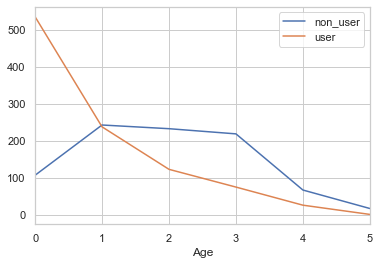

In [185]:
df_plt.plot();

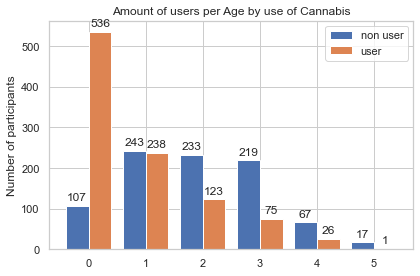

In [194]:
labels = df_plt.index
non_user = df_plt.non_user
user = df_plt.user

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_user, width, label='non user')
rects2 = ax.bar(x + width/2, user, width, label='user')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of participants')
ax.set_title('Amount of users per Age by use of Cannabis')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


# Correlation Plot

After looking at a heatmap of all features, we deleted the ones with no correlation for a better view.

In [40]:
df.columns

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism',
       'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness',
       'Impulsive', 'Sensation-Seeking', 'Alcohol', 'Amphet', 'Amyl', 'Benzos',
       'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin',
       'Ketamine', 'Legalh', 'LSD', 'Meth', 'Shrooms', 'Nicotine', 'Semer',
       'VSA', 'country', 'ethnicity'],
      dtype='object')

(0.0, 26.0)

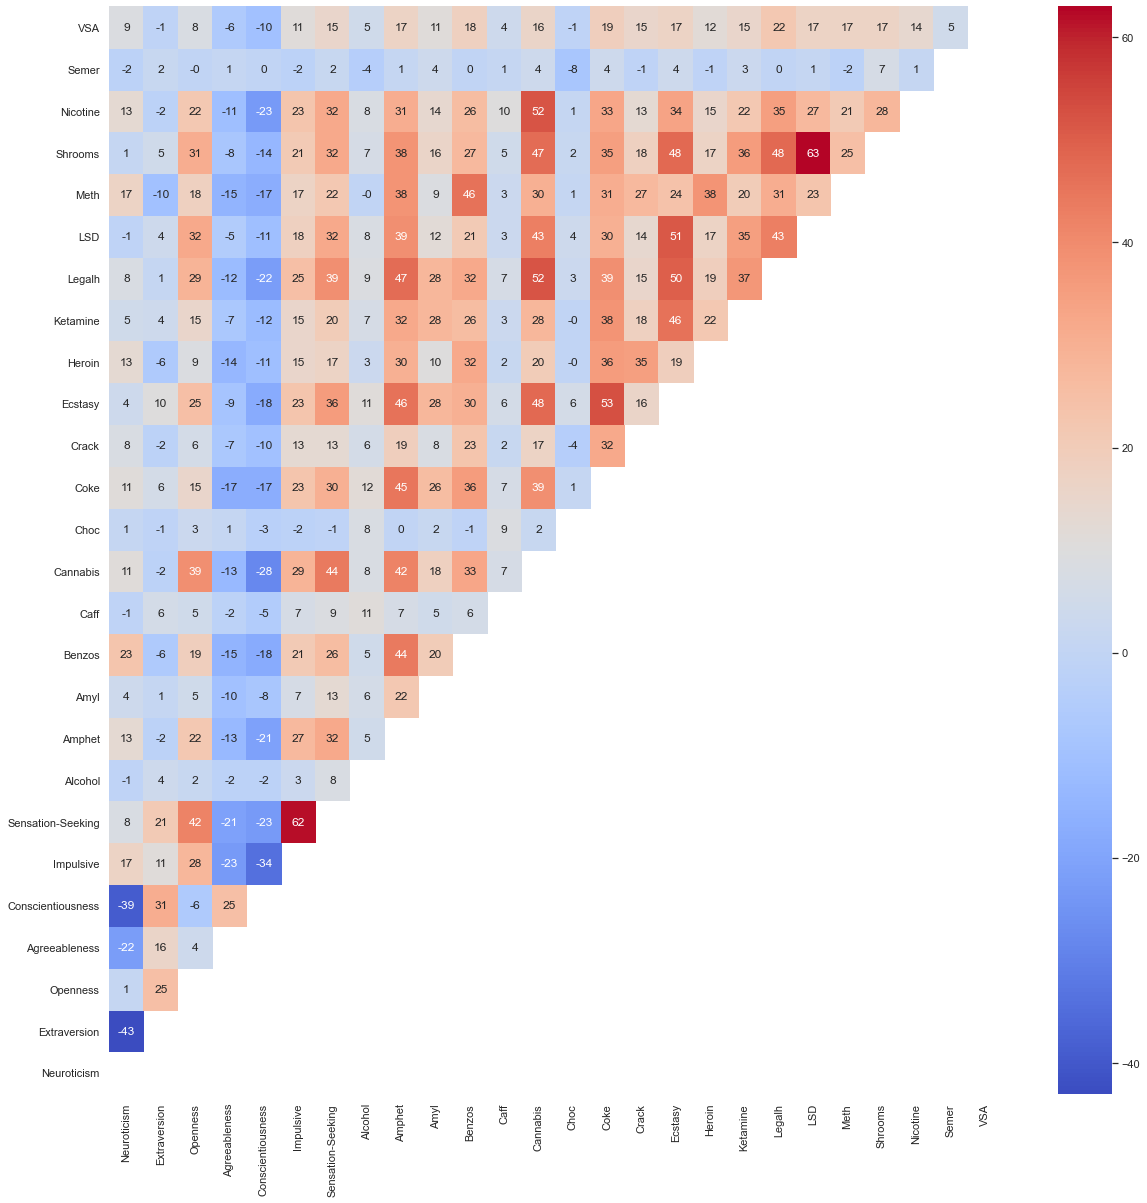

In [41]:
cont_var = ['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 
            'Conscientiousness', 'Impulsive', 'Sensation-Seeking']
cat_var=['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc',
       'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD',
       'Meth', 'Shrooms', 'Nicotine', 'Semer', 'VSA']
#cont_var

fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
X_dum = pd.get_dummies(df[cont_var+cat_var].copy(), drop_first=True)
#X_dum.head()
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')
ax.set_ylim((0,26))
#plt.savefig(‘figures/correlogram.png’)

# Shuffle and Split Data

We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [42]:
features = ['Age', 'Gender', 'Education', 'Neuroticism', 'Extraversion', 'Openness',
            'Agreeableness', 'Conscientiousness', 'Impulsive', 'Sensation-Seeking']
label = ['Cannabis']

In [43]:
X = df[features]
y = df[label]

In [44]:
#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1319 samples.
Testing set has 566 samples.


# Prediction of Cannabis Use based on Personality Traits

## Label: Cannabis Use

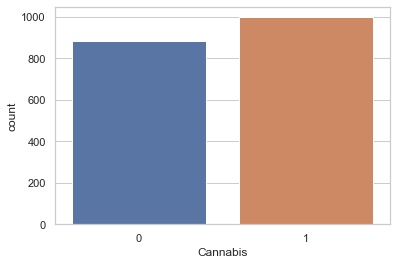

In [45]:
sns.countplot(df['Cannabis']);

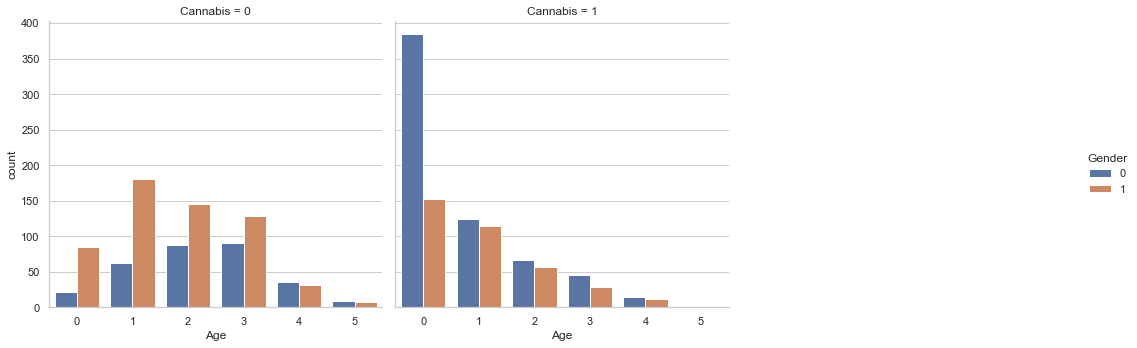

In [46]:
sns.catplot('Age', col='Cannabis', data=df, hue='Gender', kind='count', col_wrap=3);

## Model Selection

Let's train and test the models on training sets of different sizes to see how it affects their runtime and predictive performance (both on the test, and training sets).

### KNN

In [47]:
#from sklearn.metrics import confusion_matrix
#from sklearn.neighbors import KNeighborsClassifier

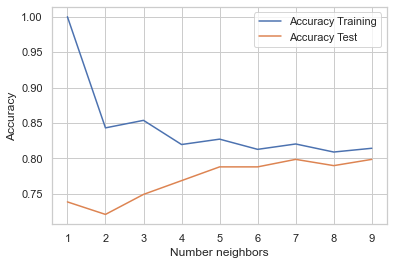

In [48]:
# Correlation Plotsns.catplot('Age', col='Cannabis', data=df, hue='Gender', kind='count', col_wrap=3);
train_accuracy = []
test_accuracy = []

# Probiere Werte für k von 1 bis 10 aus
neighbor_settings = range(1, 10)

for k in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbor_settings, train_accuracy, label='Accuracy Training')
plt.plot(neighbor_settings, test_accuracy, label='Accuracy Test')
plt.ylabel('Accuracy')
plt.xlabel('Number neighbors')
plt.legend();

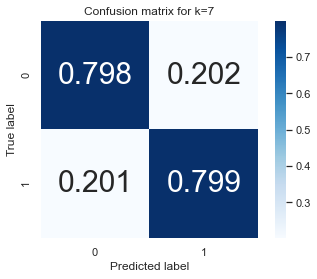

In [49]:
clf_7 = KNeighborsClassifier(n_neighbors=7)
clf_7.fit(X_train, y_train)
#train_accuracy.append(clf.score(X_train, y_train))
#test_accuracy.append(clf.score(X_test, y_test))

cm = confusion_matrix(y_test, clf_7.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for k=7'.format());

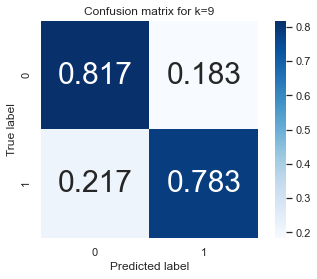

In [50]:
clf_9 = KNeighborsClassifier(n_neighbors=9)
clf_9.fit(X_train, y_train)
#train_accuracy.append(clf.score(X_train, y_train))
#test_accuracy.append(clf.score(X_test, y_test))

cm = confusion_matrix(y_test, clf_9.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
#plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for k=9'.format());

In [51]:
#from sklearn.metrics import classification_report
print(classification_report(y_test, clf_9.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       257
           1       0.84      0.78      0.81       309

    accuracy                           0.80       566
   macro avg       0.80      0.80      0.80       566
weighted avg       0.80      0.80      0.80       566



### LR, RFC, SVC, XGB

In [52]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
#from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [53]:
# TODO: Import the three supervised learning models from sklearn
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
#from time import time

# TODO: Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = LogisticRegression(random_state=101)
clf_B = RandomForestClassifier(random_state = 101)
clf_C = SVC(random_state = 101)
clf_D = KNeighborsClassifier(n_neighbors=7)
clf_E = XGBClassifier(random_state=101)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 13 samples.
LogisticRegression trained on 132 samples.
LogisticRegression trained on 1319 samples.
RandomForestClassifier trained on 13 samples.
RandomForestClassifier trained on 132 samples.
RandomForestClassifier trained on 1319 samples.
SVC trained on 13 samples.
SVC trained on 132 samples.
SVC trained on 1319 samples.
KNeighborsClassifier trained on 13 samples.
KNeighborsClassifier trained on 132 samples.
KNeighborsClassifier trained on 1319 samples.
XGBClassifier trained on 13 samples.
XGBClassifier trained on 132 samples.
XGBClassifier trained on 1319 samples.


## Model Evaluation

### Classification Report

In [54]:
## Model Evaluation

### Classification Report
for x in [clf_A, clf_B, clf_C, clf_D]:
    print('Classification Report for {}'.format(x))
    print(classification_report(y_test, x.predict(X_test)))
    print('\n\n')

Classification Report for LogisticRegression(random_state=101)
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       257
           1       0.82      0.78      0.80       309

    accuracy                           0.79       566
   macro avg       0.78      0.79      0.79       566
weighted avg       0.79      0.79      0.79       566




Classification Report for RandomForestClassifier(random_state=101)
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       257
           1       0.84      0.79      0.81       309

    accuracy                           0.80       566
   macro avg       0.80      0.81      0.80       566
weighted avg       0.81      0.80      0.80       566




Classification Report for SVC(random_state=101)
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       257
           1       0.83      0.78      0.80       309

### Time, Accuracy, F-Beta

In [55]:
#results

In [56]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
acc_test,0.699647,0.757951,0.786219
acc_train,0.676667,0.823333,0.773333
f_test,0.708491,0.786249,0.810449
f_train,0.691658,0.836386,0.791411
pred_time,0.002975,0.003008,0.002990
train_time,0.007632,0.006888,0.011848


RandomForestClassifier


,1%,10%,100%
acc_test,0.683746,0.779152,0.803887
acc_train,0.646667,0.850000,1.000000
f_test,0.691037,0.799087,0.831622
f_train,0.664100,0.870394,1.000000
pred_time,0.028797,0.025331,0.029605
train_time,0.086672,0.089050,0.161035


SVC


,1%,10%,100%
acc_test,0.545936,0.765018,0.793286
acc_train,0.546667,0.806667,0.800000
f_test,0.600466,0.791246,0.821355
f_train,0.599706,0.822086,0.819775
pred_time,0.002925,0.004632,0.013355
train_time,0.001968,0.002902,0.029820


KNeighborsClassifier


,1%,10%,100%
acc_test,0.584806,0.742049,0.798587
acc_train,0.586667,0.740000,0.793333
f_test,0.621720,0.762332,0.820598
f_train,0.621663,0.758123,0.817369
pred_time,0.029017,0.024241,0.035512
train_time,0.002584,0.002870,0.003375


XGBClassifier


,1%,10%,100%
acc_test,0.591873,0.752650,0.784452
acc_train,0.620000,0.840000,0.870000
f_test,0.625832,0.775805,0.817544
f_train,0.642434,0.857322,0.884184
pred_time,0.002361,0.003835,0.003917
train_time,0.006895,0.017089,0.088236


### Confusion Matrix 

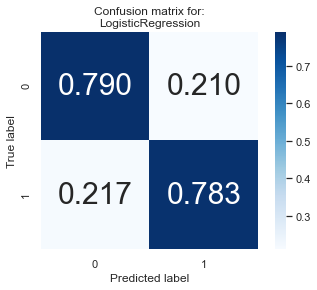

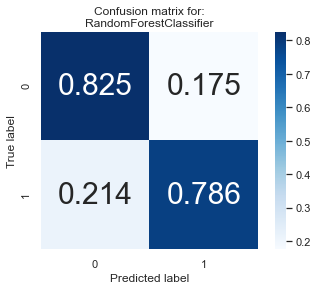

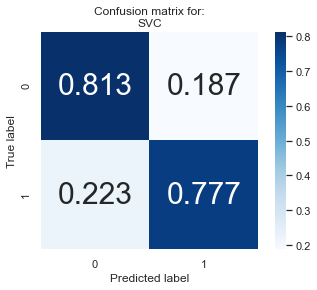

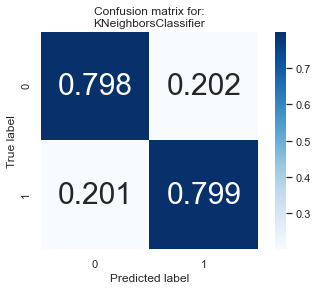

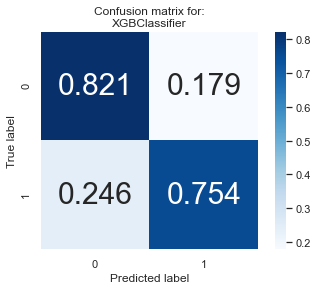

In [57]:
### Confusion Matrix #Visualizing the confusion matrix for each classifier
#from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C, clf_D, clf_E]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

## GridSearch

Scikit-Learn’s GridSearchCV uses use cross-validation to evaluate all the possible combinations of hyperparameter values. We apply GridSearch to all four models that we have looked at so far. 

In [58]:
my_scorer = make_scorer(f1_score, average='weighted')

### KNN

In [225]:
param_grid = {'n_neighbors' : list(range(1,50)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,50))
             #'metrics': ['euclidean','manhattan']
             }

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, 
                        cv=KFold(3, random_state=42), verbose=True, n_jobs=-1,
                       scoring=my_scorer,)
best_knn = grid_knn.fit(X_train, y_train)

Fitting 3 folds for each of 4802 candidates, totalling 14406 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 6448 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 13648 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 14391 out of 14406 | elapsed:  1.8min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 14406 out of 14406 | elapsed:  1.8min finished


In [226]:
y_pred = best_knn.predict(X_test)

In [227]:
print(f'Optimized F1 Score: {(best_knn.best_score_)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')
print(f'Best known parameters: {best_knn.best_params_}')
#print(best_knn.best_estimator_)

Optimized F1 Score: 78.57
Optimized Accuracy: 78.09
Optimized Precision: 83.39
Optimized Recall: 74.76
Best known parameters: {'leaf_size': 1, 'n_neighbors': 49, 'weights': 'distance'}


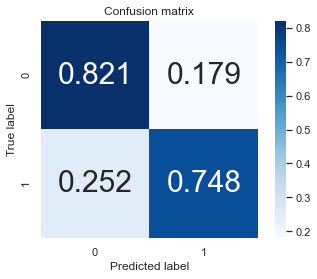

In [62]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77       257
           1       0.83      0.75      0.79       309

    accuracy                           0.78       566
   macro avg       0.78      0.78      0.78       566
weighted avg       0.79      0.78      0.78       566



**Optimization KNN Model**: 
 
We obtain the best solution by setting the *leaf_size hyperparameter* to 1, the *n_neighbors hyperparameter* to 49 und *weights hyperparameter* to 'distance'. The **F1 score** for this combination is 0.7863 and the **Accuracy** is 0.7809, which is slightly worse than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** decreased for the 'Non-User'- group and stayed the same for the 'User' - group. **Recall** increased for the 'Non-User'- group and decreased for the 'User' - group. 

### LR

In [220]:
c = list(range(1, 100))
param_grid = {'C': c,
             'penalty':['l1', 'l2'], 
             'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
             }
#cv = 
logreg = LogisticRegression()
grid_lr = GridSearchCV(logreg, param_grid=param_grid, 
                        cv=KFold(3, random_state=42) , 
                        verbose=True, n_jobs=-1,
                        scoring=my_scorer)
best_lr = grid_lr.fit(X_train, y_train)

Fitting 3 folds for each of 990 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   14.0s finished


In [221]:
y_pred = best_lr.predict(X_test)

In [224]:
print(f'Optimized F1 Score: {(best_lr.best_score_)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')
print(f'Best known parameters: {best_lr.best_params_}')
#print(best_lr.best_estimator_)

Optimized F1 Score: 79.09
Optimized Accuracy: 78.62
Optimized Precision: 81.76
Optimized Recall: 78.32
Best known parameters: {'C': 2, 'penalty': 'l1', 'solver': 'saga'}


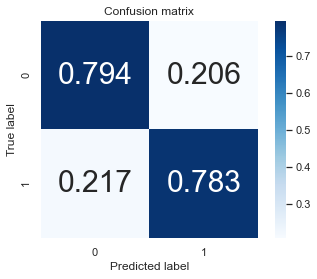

In [67]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       257
           1       0.82      0.78      0.80       309

    accuracy                           0.79       566
   macro avg       0.79      0.79      0.79       566
weighted avg       0.79      0.79      0.79       566



**Optimization LR Model**: 
 
We obtain the best solution by setting the *C hyperparameter* to 77, the *penalty hyperparameter* to l2 und *solver hyperparameter* to 'sag'. The **F1 score** for this combination is 0.7907 and the **Accuracy** is 0.7862, which is slightly worse/better than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** and **recall** did not change for any of the groups. 

### Random Forest

In [228]:
param_grid = {'n_estimators' : list(range(1,30)),
             'max_depth': [5, 8, 15, 25, 30],
             #'min_samples_leaf' : list(range(1,50)),
             'max_features' : ['auto', 'sqrt'],
             'min_samples_split' : [2, 5, 10]}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, 
                        cv=KFold(3, random_state=42), verbose=True, n_jobs=-1,
                       scoring=my_scorer)
best_rf = grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 870 candidates, totalling 2610 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 2610 out of 2610 | elapsed:   30.2s finished


In [230]:
y_pred = best_rf.predict(X_test)

In [231]:
print(f'Optimized F1 Score: {(best_rf.best_score_)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')
print(f'Best known parameters: {best_rf.best_params_}')
#print(best_rf.best_estimator_)

Optimized F1 Score: 79.47
Optimized Accuracy: 78.98
Optimized Precision: 83.69
Optimized Recall: 76.38
Best known parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 23}



|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: |
| Accuracy Score |        0.8039     |      0.8188     |
| F-score        |        0.0000     |      0.0000     |

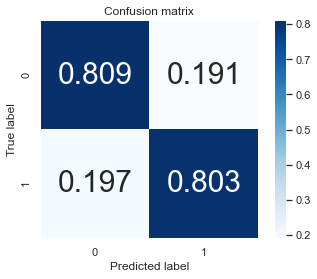

In [85]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       257
           1       0.84      0.80      0.82       309

    accuracy                           0.81       566
   macro avg       0.80      0.81      0.80       566
weighted avg       0.81      0.81      0.81       566



**Optimization Random Forest Model**: 
 
We obtain the best solution by setting the *max_depth hyperparameter* to 5, the *max_features hyperparameter* to 'sqrt' und *n_estimators hyperparameter* to 16. The **F1 score** for this combination is 0.7903 and the **Accuracy** is 0.8021, which is slightly worse than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** slightly increased for the 'User'- group and **recall** slightly increased for both groups. 

#### Feature Importance

An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual has an increased risk for drug usage or not. 

In [87]:
feature_importances = best_rf.best_estimator_.feature_importances_
sorted(zip(feature_importances, features), reverse=True)

[(0.2637546091840371, 'Age'),
 (0.22638446489195743, 'Sensation-Seeking'),
 (0.1508310237193472, 'Openness'),
 (0.09214179938336493, 'Education'),
 (0.09074213370323589, 'Conscientiousness'),
 (0.04271431780675956, 'Gender'),
 (0.038008663163416084, 'Impulsive'),
 (0.03444196303063838, 'Agreeableness'),
 (0.03253386681783118, 'Neuroticism'),
 (0.028447158299412245, 'Extraversion')]

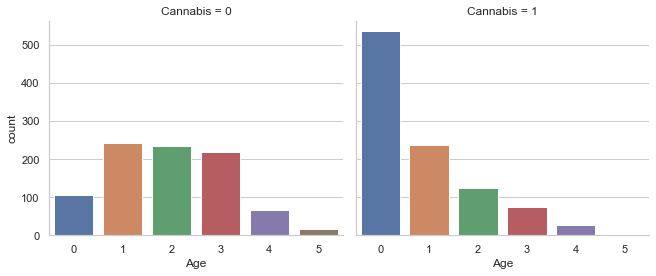

In [88]:
sns.catplot(x="Age", col="Cannabis", col_wrap=4, data=df, kind="count", height=4, aspect=1.1);

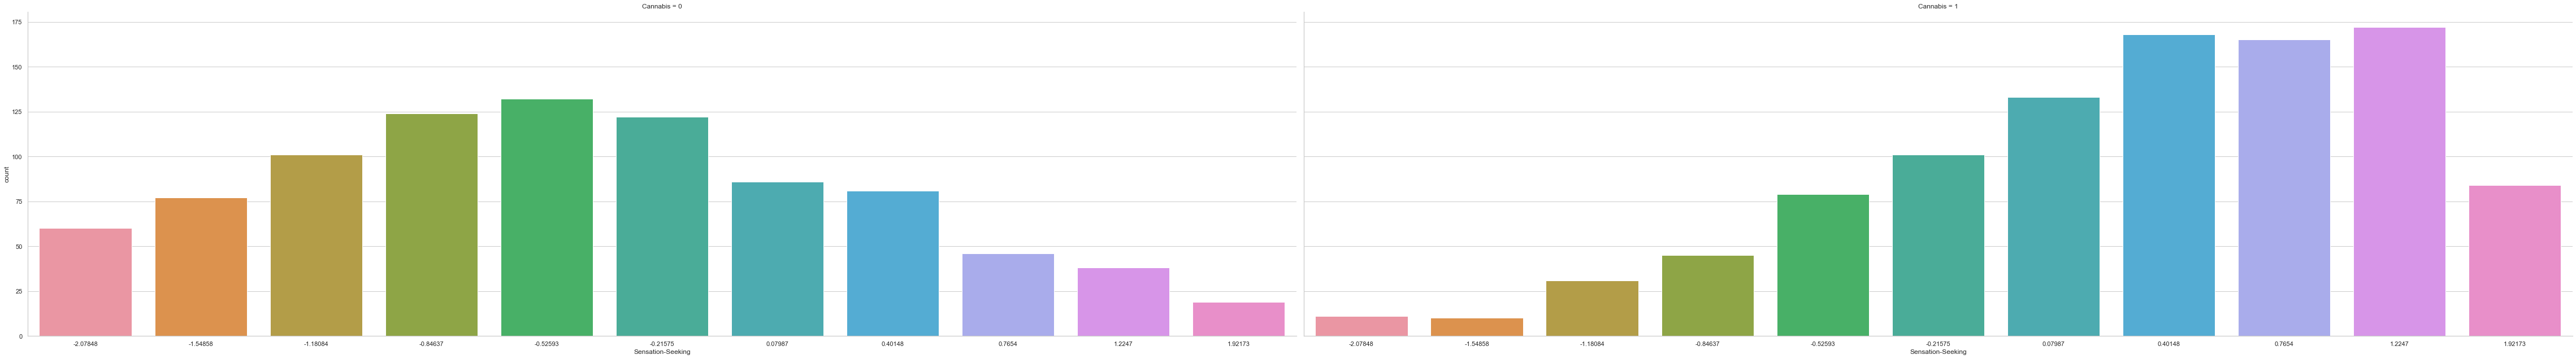

In [89]:
sns.catplot(x="Sensation-Seeking", col="Cannabis", col_wrap=4, data=df, kind="count", height=9, aspect=3.5);

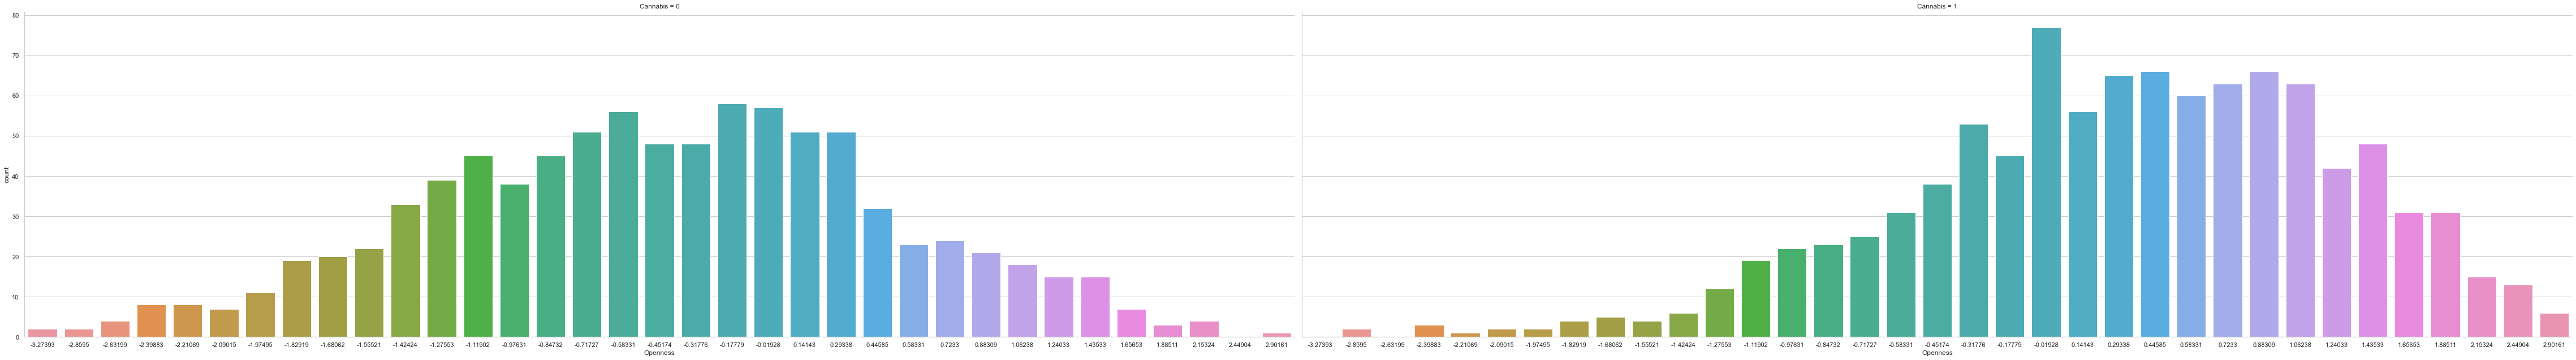

In [90]:
sns.catplot(x="Openness", col="Cannabis", col_wrap=4, data=df, kind="count", height=9, aspect=3.5);

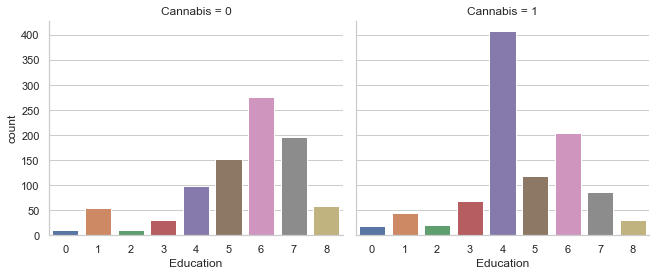

In [91]:
sns.catplot(x="Education", col="Cannabis", col_wrap=4, data=df, kind="count", height=4, aspect=1.1);

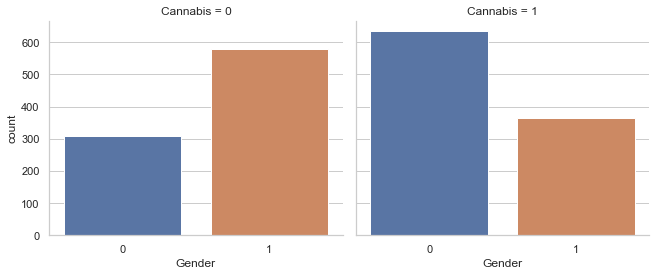

In [92]:
sns.catplot(x="Gender", col="Cannabis", col_wrap=4, data=df, kind="count", height=4, aspect=1.1);

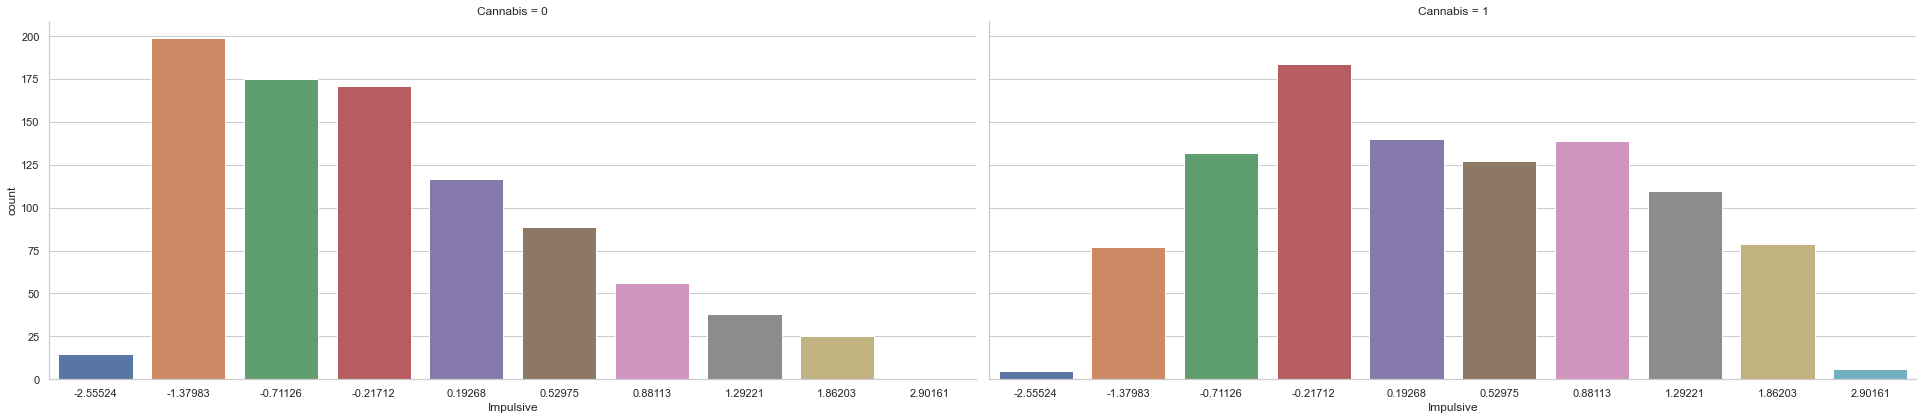

In [93]:
sns.catplot(x="Impulsive", col="Cannabis", col_wrap=4, data=df, kind="count", height=6, aspect=2.2);

### SVC

Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel) to determine the best model. 

In [232]:
param_grid = {'C': [1, 5, 10, 50],
             #'gamma': [0.0001, 0.0005, 0.001, 0.005],
             'kernel': ['linear', 'rbf', 'poly']
             }

grid_svc = GridSearchCV(SVC(), param_grid=param_grid, 
                        cv=KFold(3, random_state=42), 
                        verbose=True, n_jobs=-1,
                       scoring=my_scorer)
best_svc = grid_svc.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.1s finished


In [233]:
y_pred = best_svc.predict(X_test)

In [234]:
print(f'Optimized F1 Score: {(best_svc.best_score_)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')
print(f'Best known parameters: {best_svc.best_params_}')
#print(best_svc.best_estimator_)

Optimized F1 Score: 78.94
Optimized Accuracy: 79.33
Optimized Precision: 83.33
Optimized Recall: 77.67
Best known parameters: {'C': 1, 'kernel': 'rbf'}


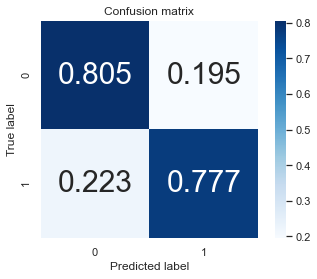

In [97]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       257
           1       0.83      0.78      0.80       309

    accuracy                           0.79       566
   macro avg       0.79      0.79      0.79       566
weighted avg       0.79      0.79      0.79       566



**Optimization SVC Model**: 
 
We obtain the best solution by setting the *C hyperparameter* to 5 and the *kernel hyperparameter* to 'linear'. Unfortunately, we were not able to inspect more hyperparameters due to limited power. The **F1 score** for this combination is 0.7900 and the **Accuracy** is 0.7897, which is slightly worse/better than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** and **recall** remained the same for both groups. 

### XGBoost

*max_depth*: maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.

*min_child_weight*: minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

*subsample*: corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.

In [239]:
max_d = list(range(1,5))
min_child = list(range(0,15))

param_grid = {'max_depth': max_d,
             'min_child_weight': min_child,
             #'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
             #'eta': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
             'subsample': [0.01, 0.1, 0.5, 1]
             #'colsample_bytree': [X],
             #'objective': [X]
             }

xgb = XGBClassifier()
grid_xgb = GridSearchCV(xgb, param_grid=param_grid, 
                        cv=KFold(3, random_state=42) , 
                        verbose=True, n_jobs=-1,
                        scoring=my_scorer)
best_xgb = grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  1.0min finished


In [240]:
y_pred = best_xgb.predict(X_test)

In [241]:
print(f'Optimized F1 Score: {(best_xgb.best_score_)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')
print(f'Best known parameters: {best_xgb.best_params_}')
#print(best_xgb.best_estimator_)

Optimized F1 Score: 79.62
Optimized Accuracy: 80.21
Optimized Precision: 83.62
Optimized Recall: 79.29
Best known parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 14, 'subsample': 0.5}


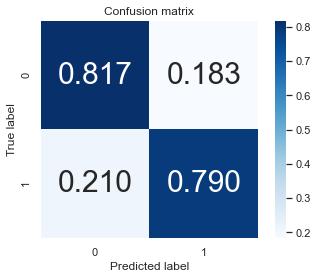

In [102]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix'.format());

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       257
           1       0.84      0.79      0.81       309

    accuracy                           0.80       566
   macro avg       0.80      0.80      0.80       566
weighted avg       0.80      0.80      0.80       566



**Optimization XGBoost Model**: 
 
We obtain the best solution by setting the *max_depth hyperparameter* to 2 and the *min_child_weight hyperparameter* to 10 and *subsample hyperparameter* to 1. The **F1 score** for this combination is 0.7984 and the **Accuracy** is 0.8021, which is slightly worse/better than the score we got prior to optimizing the model (F1: , Accuracy: ). In the optimized model, **precision** for the non-user group slightly increased and for the user-group remained the same. **Recall** increased for the user-group and remained the same for the non-user group. 

## Summary

In [359]:
def modelling(clf, grid, cv, score, data):
    """
        clf: Instance of the modell
        grid: parameter grid
        cv: crossvalidation
        score: scoring parameter
        data: data to use as list(train/test-split)
    """
    X_train, X_test, y_train, y_test = data
    
    grid_model = GridSearchCV(clf, param_grid=grid, 
                        cv=cv, 
                        verbose=True, n_jobs=-1,
                        scoring=score)
    best_model = grid_model.fit(X_train, y_train)
    #model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    scores = {'test':{},
             'train': {}}
    scores['params'] = best_model.best_params_
    scores['test'] = {'f1': f1_score(y_test, y_pred),
                      'accuracy': accuracy_score(y_test, y_pred),
                      'precision': precision_score(y_test, y_pred),
                      'recall': recall_score(y_test, y_pred)}
    return scores

Test of the function with XGBoost

In [362]:
X = df[features]
y = df[label]
param_grid = {'max_depth': list(range(1,5)),
             'min_child_weight': list(range(0,15)),
             #'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
             #'eta': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
             'subsample': [0.01, 0.1, 0.5, 1]
             #'colsample_bytree': [X],
             #'objective': [X]
             }
xgb = XGBClassifier()
c = KFold(3, random_state=42)
d = train_test_split(X, y, test_size = 0.3, random_state = 42)

a = modelling(xgb, param_grid, c, my_scorer, d)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   11.1s finished


In [363]:
a

{'test': {'f1': 0.813953488372093,
  'accuracy': 0.8021201413427562,
  'precision': 0.8361774744027304,
  'recall': 0.7928802588996764},
 'train': {},
 'params': {'max_depth': 3, 'min_child_weight': 14, 'subsample': 0.5}}

# Model using for different drugs

In [253]:
import random
random.randint(1,10)

9

In [270]:
# Creating list of labels
labels = drugs.copy()

# playground
r = random.randint(0, len(labels))

# set features
X = df[features]
y = df[labels[r]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(f'Train/Test-Split for drug: {labels[r]}')
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Train/Test-Split for drug: Alcohol
Training set has 1319 samples.
Testing set has 566 samples.


In [285]:
results = {}
for x in labels:
    y = df[x]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.3, 
                                                        random_state = 42)
    model = XGBClassifier(**best_xgb.best_params_)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'Optimized F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
    print(f'Optimized Accuracy {x}: {accuracy_score(y_test, y_pred)*100:.2f}')
    #f = [f1_score(y_test, y_pred), accuracy_score(y_test, y_pred), 
    #     precision_score(y_test, y_pred), recall_score(y_test, y_pred)]
                
    #results[y] = f

Optimized F1 Score: 96.24
Optimized Accuracy Alcohol: 92.76
Optimized F1 Score: 41.15
Optimized Accuracy Amphet: 78.27
Optimized F1 Score: 0.00
Optimized Accuracy Amyl: 92.93
Optimized F1 Score: 40.46
Optimized Accuracy Benzos: 72.44
Optimized F1 Score: 98.29
Optimized Accuracy Caff: 96.64
Optimized F1 Score: 81.40
Optimized Accuracy Cannabis: 80.21
Optimized F1 Score: 98.84
Optimized Accuracy Choc: 97.70
Optimized F1 Score: 37.19
Optimized Accuracy Coke: 77.92
Optimized F1 Score: 0.00
Optimized Accuracy Crack: 95.58
Optimized F1 Score: 49.83
Optimized Accuracy Ecstasy: 74.38
Optimized F1 Score: 0.00
Optimized Accuracy Heroin: 93.64
Optimized F1 Score: 2.90
Optimized Accuracy Ketamine: 88.16
Optimized F1 Score: 61.39
Optimized Accuracy Legalh: 78.45
Optimized F1 Score: 44.10
Optimized Accuracy LSD: 80.74
Optimized F1 Score: 23.26
Optimized Accuracy Meth: 82.51
Optimized F1 Score: 48.07
Optimized Accuracy Shrooms: 78.62
Optimized F1 Score: 75.88
Optimized Accuracy Nicotine: 72.26
Optimi

The model for Cannabis does not work for the other drugs. That result was expected. As we can see below, other drug usage are not balanced.

In [271]:
model = XGBClassifier(**best_xgb.best_params_)
model.fit(X_train, y_train)

XGBClassifier(min_child_weight=14, subsample=0.5)

In [272]:
y_pred = model.predict(X_test)

In [273]:
print(f'Optimized F1 Score: {(best_xgb.best_score_)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')

Optimized F1 Score: 79.62
Optimized Accuracy: 92.76
Optimized Precision: 92.76
Optimized Recall: 100.00


In [275]:
df[df[labels[r]] == 1].count()

Age                  1749
Gender               1749
Education            1749
Country              1749
Ethnicity            1749
Neuroticism          1749
Extraversion         1749
Openness             1749
Agreeableness        1749
Conscientiousness    1749
Impulsive            1749
Sensation-Seeking    1749
Alcohol              1749
Amphet               1749
Amyl                 1749
Benzos               1749
Caff                 1749
Cannabis             1749
Choc                 1749
Coke                 1749
Crack                1749
Ecstasy              1749
Heroin               1749
Ketamine             1749
Legalh               1749
LSD                  1749
Meth                 1749
Shrooms              1749
Nicotine             1749
Semer                1749
VSA                  1749
country              1749
ethnicity            1749
dtype: int64

## Drug Classification

In [288]:
print(drugs)

['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LSD', 'Legalh', 'Meth', 'Nicotine', 'Shrooms', 'VSA']


In [292]:
to_drop = ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 
 'Choc', 'Crack',  'Ketamine', 
 'Legalh', 'Nicotine', 'Shrooms', 'VSA']

Drugs that have a high rate of potential abuse along with significant psychological or physical dependence

In [296]:
hard1 = ['Heroin', 'Ecstasy', 'LSD', 'Coke', 'Meth']

In [289]:
df_hard1 = df.copy()

In [293]:
df_hard1.drop(columns=to_drop, inplace=True)

In [294]:
df_hard1.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsive,Sensation-Seeking,Coke,Ecstasy,Heroin,LSD,Meth,Semer,country,ethnicity
0,2,1,5,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0,0,0,0,0,0,UK,mix_wh_as
1,1,1,7,0.96082,0.126,3.27393,-1.50796,-0.31776,0.59042,-0.65253,-1.37983,0.40148,0,0,0,0,0,0,UK,mix_wh_as
2,0,0,6,0.96082,0.126,-0.34799,1.28610,-1.11902,0.59042,-0.52745,0.52975,0.07987,0,0,0,0,0,0,UK,mix_wh_as
3,2,1,6,0.96082,0.126,-1.05308,0.80523,-0.71727,1.28610,0.93949,-0.21712,-0.84637,0,0,0,0,0,0,UK,mix_wh_as
4,4,1,6,0.96082,0.126,-0.24649,0.96248,0.14143,-0.15487,0.41594,-1.37983,-2.07848,0,0,0,0,0,0,UK,mix_wh_as


In [301]:
df_hard1['hard_use'] = np.where(df_hard1[hard1].sum(axis=1)==0, 0, 1)

In [302]:
df_hard1.sample(10)

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsive,Sensation-Seeking,Coke,Ecstasy,Heroin,LSD,Meth,Semer,country,ethnicity,hard_use
1469,0,1,4,-0.57009,-0.31685,1.37297,0.00332,-0.01928,0.76096,-0.27607,0.19268,-0.21575,0,1,0,1,0,0,USA,white,1
218,5,0,8,0.96082,-0.31685,0.52135,-0.15487,-0.45174,-1.47955,1.81175,-0.71126,-1.54858,0,0,0,0,0,0,UK,white,0
1581,1,0,7,-0.28519,-0.31685,-0.05188,-1.37639,0.44585,-0.45321,-0.52745,0.19268,0.76540,1,1,0,1,0,0,OTHER,white,1
1561,1,0,7,-0.28519,-0.31685,-1.05308,2.57309,0.58331,-1.47955,-0.40581,-0.21712,1.22470,1,1,0,0,0,0,OTHER,white,1
243,1,0,4,0.96082,-0.31685,0.62967,0.32197,-0.71727,-0.30172,-0.00665,-0.21712,-1.54858,0,0,0,0,0,0,UK,white,0
1289,1,0,4,-0.57009,-0.31685,0.52135,-1.23177,0.44585,-3.15735,-0.52745,1.86203,1.22470,1,1,0,0,0,0,USA,white,1
1641,0,0,4,-0.28519,-0.31685,-1.32828,-0.30033,0.88309,1.11406,-1.01450,-0.71126,-0.21575,0,0,0,0,0,0,OTHER,white,0
382,0,1,6,0.96082,-0.31685,0.62967,0.00332,0.14143,0.59042,0.12331,-0.21712,0.07987,0,1,0,1,0,0,UK,white,1
1778,0,1,4,-0.57009,0.11440,-0.46725,0.80523,2.15324,0.76096,-0.27607,-1.37983,-0.84637,1,1,0,0,0,0,USA,other,1
576,0,0,4,0.96082,-0.31685,0.73545,1.11406,1.43533,-1.47955,-1.78169,0.88113,0.76540,1,1,0,0,0,0,UK,white,1


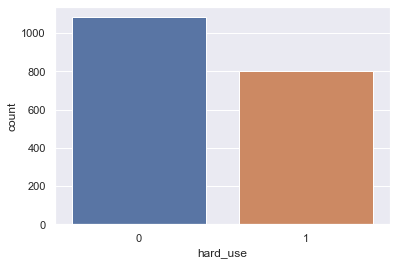

In [303]:
sns.countplot(df_hard1['hard_use']);

In [305]:
# First try for that new label the XGBoost-Classifier
X = df_hard1[features]
y = df_hard1['hard_use']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

model = XGBClassifier(**best_xgb.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Optimized F1 Score: {f1_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Precision: {precision_score(y_test, y_pred)*100:.2f}')
print(f'Optimized Recall: {recall_score(y_test, y_pred)*100:.2f}')

Optimized F1 Score: 72.84
Optimized Accuracy: 76.68
Optimized Precision: 78.32
Optimized Recall: 68.08


In [365]:
# lokal values for model-run
X = df_hard1[features]
y = df_hard1['hard_use']

c = KFold(3, random_state=42)
d = train_test_split(X, y, test_size = 0.3, random_state = 42)
grid_lr = {'C': list(range(1, 100)),
             'penalty':['l1', 'l2'], 
             'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
             }

grid_rf = {'n_estimators' : list(range(1,30)),
             'max_depth': [5, 8, 15, 25, 30],
             'max_features' : ['auto', 'sqrt'],
             'min_samples_split' : [2, 5, 10]}
grid_svm = {'C': [1, 5, 10, 50],
             'kernel': ['linear', 'rbf', 'poly']
             }

grid_xgb = {'max_depth': max_d,
             'min_child_weight': min_child,
             'subsample': [0.01, 0.1, 0.5, 1]
             }
grid_knn = {'n_neighbors' : list(range(1,50)),
             'weights': ['uniform', 'distance'],
             'leaf_size' : list(range(1,50))
             }

try_models = [['LogReg', LogisticRegression(random_state=42), grid_lr, c, my_scorer, d],
             ['RandomForest', RandomForestClassifier(random_state=42), grid_rf, c, my_scorer, d],
             ['SVM', SVC(random_state=42), grid_svm, c, my_scorer, d],
             ['XGBoost', XGBClassifier(random_state=42), grid_xgb, c, my_scorer, d],
             ['KNN', KNeighborsClassifier(), grid_knn, c, my_scorer, d]]

In [370]:
results = {m[0]:modelling(*m[1:]) for m in try_models}
#for m in try_models:
#    results[m[0]] = modelling(*m[1:])
    #results[m[0]] = modelling(m[1],m[2],m[3],m[4],m[5])

Fitting 3 folds for each of 990 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2646 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 870 candidates, totalling 2610 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 2610 out of 2610 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 4802 candidates, totalling 14406 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 2144 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 3944 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 6144 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 8744 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 11744 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 14391 out of 14406 | elapsed:  1.3min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 14406 out of 14406 | elapsed:  1.3min finished


In [371]:
test_result = {k:v['test'] for k, v in results.items()}
df_test = pd.DataFrame(test_result)

In [372]:
df_test.T.sort_values(by='f1', ascending=False)

,accuracy,f1,precision,recall
SVM,0.779152,0.748491,0.784810,0.715385
LogReg,0.780919,0.747967,0.793103,0.707692
RandomForest,0.763251,0.718487,0.791667,0.657692
KNN,0.757951,0.713987,0.780822,0.657692
XGBoost,0.754417,0.709812,0.776256,0.653846


In [373]:
df0 = df_test.T

In [374]:
df0['sum'] = df0.sum(axis=1)

In [376]:
df0.sort_values(by='sum', ascending=False)

,accuracy,f1,precision,recall,sum
LogReg,0.780919,0.747967,0.793103,0.707692,3.029682
SVM,0.779152,0.748491,0.784810,0.715385,3.027838
RandomForest,0.763251,0.718487,0.791667,0.657692,2.931097
KNN,0.757951,0.713987,0.780822,0.657692,2.910452
XGBoost,0.754417,0.709812,0.776256,0.653846,2.894331


# Testcells

In [ ]:
# Create first pipeline for base without reducing features.
pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])
# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20)},
    #'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))},
    {'classifier': [SVC()],
     'classifier__C': [1, 5, 10, 50],
     'classifier__gamma': [0.0001, 0.0005, 0.001, 0.005]
    }
]
# Create grid search object
clf = GridSearchCV(pipe, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1)
# Fit on data
best_clf = clf.fit(X_train, y_train)

In [ ]:
best_clf.best_estimator_ 

In [ ]:
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 
               
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

In [ ]:
# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scorer) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_clf = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([('scaler', MinMaxScaler()),('svm', SVC())])
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.score(X_test, y_test))
print(grid.best_params_)

Copy and Paste:

In [ ]:
# TODO: Initialize the classifier
#clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 
parameters = {'classifier__penalty' : ['l1', 'l2'],
             'classifier__C' : np.logspace(-4, 4, 20)}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scorer) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 

# Get the estimator
best_clf = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)